In [1]:
# Import Pandas for data structure manipulations.
import pandas as pd

# Import NumPy for numerical analysis.
import numpy as np

# Import a timer.
import time

from category_encoders import TargetEncoder

# Import the train_test_split, cross-validation, and grid search modules from Scikit-Learn.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Import the One-Hot Encoder, Target Encoder, StandardScaler for later categorical to numeric encoding.
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Import the column transformer that can be used for scaling purposes in later steps.
from sklearn.compose import make_column_transformer

# Import the pipeline module for step-wise transformations in later steps.
from sklearn.pipeline import make_pipeline

# Import the mean_squared_error module from Scikit-Learn as a quick error metric.
from sklearn.metrics import accuracy_score, make_scorer, mean_squared_error

# Import DecisionTreeClassifer and tree visualizatoin methods from Scikit-Learn.
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Use the experimental method in Scikit-Learn to enable HistGradientBoostingClassifier.
from sklearn.experimental import enable_hist_gradient_boosting

# Import the RandomForestClassifier, GradientBoostingClassifier, and HistGradientBoostingClassifier from Scikit-Learn.
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay

from sklearn.metrics import average_precision_score
# Import the XGBoost module from Scikit-Learn. Be sure to 'brew install cmake' in CLI.
# Next, 'pip install xgboost' in CLI or do a '!pip install xgboost' in iPython. This makes XGBoost accessible.
!pip install xgboost
import xgboost as xgb

# Import MatPlotLib for data exploration and visualizations.
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# Ignore unnecessary warnings. This will clean up output appearances.
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.svm import LinearSVC, SVC

import seaborn as sns

import gc

C:\Users\yh3184\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
# read training set and preprocessing 
## didn't include imputed orig_destination_distance
def train_data():
    # Specify the name of the local 'data' directory data files will be stored.
    data_folder = 'data/'

    # Specify the data file extension .csv that training and test sets will be pulled from.
    csv_extension = '.csv'
    # Grab the training data available from the data directory.
    train = pd.read_csv(data_folder + 'train' + csv_extension, parse_dates = [0,11,12])
    train = train.drop(columns=['orig_destination_distance', 'posa_continent','user_id','is_mobile'], axis = 1)
    train = train.dropna()
    
    train['srch_ci'] = pd.to_datetime(train['srch_ci'], errors='coerce')
    train['srch_co'] = pd.to_datetime(train['srch_co'], errors='coerce')
    train['srch_before_ci'] = pd.to_numeric((train['srch_ci'] - train['date_time']).dt.days, errors='coerce', downcast='integer')
    train['srch_trip_duration'] = pd.to_numeric((train['srch_co'] - train['srch_ci']).dt.days, errors='coerce', downcast='integer')
    train['day_of_year_srch'] = train['date_time'].dt.dayofyear
    train = train.dropna()
    train.reset_index(drop=True, inplace = True)
    
    train['encoded_day_of_year_srch'] = train['day_of_year_srch']
    TE_col = [
        'site_name',
        'user_location_country',
        'user_location_region',
        'user_location_city',
        'channel',
        'cnt',
        'hotel_continent',
        'hotel_country',
        'hotel_market',
        'encoded_day_of_year_srch'
    ]
    train[TE_col] = TargetEncoder(
        cols = TE_col, 
        smoothing=0
    ).fit_transform(train[TE_col].astype('category'), train['is_booking'])
    
    OHE = OneHotEncoder()
    OHE_col = [
        'srch_destination_type_id',
    ]
    train = pd.concat(
        [
            train,
            pd.DataFrame(
                OHE.fit_transform(train[OHE_col].astype('category')).toarray(), 
                columns=OHE.get_feature_names_out(OHE_col)
            )
        ],
        axis=1
    )
    train = train.drop(columns=OHE_col, axis=1)
    
    train = train.drop(columns=['srch_ci','srch_co', 'date_time', 'day_of_year_srch'], axis = 1)
    return train

In [3]:
# read destination set
def pca_dest():
    data_folder = 'data/'
    csv_extension = '.csv'
    destinations = pd.read_csv(data_folder + 'destinations' + csv_extension, index_col=0)
    pca = PCA(n_components = 0.8)
    X_pca = pca.fit_transform(destinations)
    X_pca_df = pd.DataFrame(X_pca, index=destinations.index)
    rows, cols = X_pca.shape
    return X_pca_df

In [4]:
train = train_data()

In [5]:
dest_pca = pca_dest()

In [6]:
delete_destination_id = list(set(train['srch_destination_id']) - set(dest_pca.index))

In [7]:
train.drop(train[train['srch_destination_id'].isin(delete_destination_id)].index, inplace=True)

In [8]:
train.isnull().sum()

site_name                     0
user_location_country         0
user_location_region          0
user_location_city            0
is_package                    0
channel                       0
srch_adults_cnt               0
srch_children_cnt             0
srch_rm_cnt                   0
srch_destination_id           0
is_booking                    0
cnt                           0
hotel_continent               0
hotel_country                 0
hotel_market                  0
hotel_cluster                 0
srch_before_ci                0
srch_trip_duration            0
encoded_day_of_year_srch      0
srch_destination_type_id_0    0
srch_destination_type_id_1    0
srch_destination_type_id_2    0
srch_destination_type_id_3    0
srch_destination_type_id_4    0
srch_destination_type_id_5    0
srch_destination_type_id_6    0
srch_destination_type_id_7    0
srch_destination_type_id_8    0
srch_destination_type_id_9    0
dtype: int64

In [9]:
# scaler if needed

In [10]:
#################################

In [11]:
def split_data(train, down_sample):
    # break test set, where only booking events are included
    test = train[train['is_booking'] == 1].sample(frac = 0.2, random_state=42)
    train.drop(test.index, inplace=True)
    
    # seperate target from feature 
    if down_sample == True:
        not_book = train[train['is_booking'] == 0]
        book = train[train['is_booking'] == 1]
        train = pd.concat([not_book.sample(len(book)), book])    
    print(train.shape)
    
    train_y = train['hotel_cluster'].astype('category')
    train.drop(columns=['hotel_cluster'], inplace=True)
    y_test = test['hotel_cluster'].astype('category')
    test.drop(columns=['hotel_cluster'], inplace=True)
    x_test = test
    
    # split training set to train and val
    x_train, x_val, y_train, y_val = train_test_split(train, train_y, stratify=train['is_booking'], test_size=0.2, random_state=42)
    
    return x_train, x_val, x_test, y_train, y_val, y_test

In [12]:
x_train, x_val, x_test, y_train, y_val, y_test = split_data(train, down_sample=True)

(4781084, 29)


In [13]:
del train
gc.collect()

0

In [14]:
# join destination data by srch_destination_id
def join_dest(x):
    dest_pca['srch_destination_id'] = dest_pca.index
    x= x.join(dest_pca, on='srch_destination_id', lsuffix='_caller', rsuffix='_other')
    x.drop(columns=['srch_destination_id_caller','srch_destination_id_other'], axis=1, inplace=True)
    return x

In [15]:
x_train = join_dest(x_train)
x_val = join_dest(x_val)
x_test = join_dest(x_test)

In [16]:
x_train.isnull().sum()

site_name                     0
user_location_country         0
user_location_region          0
user_location_city            0
is_package                    0
channel                       0
srch_adults_cnt               0
srch_children_cnt             0
srch_rm_cnt                   0
is_booking                    0
cnt                           0
hotel_continent               0
hotel_country                 0
hotel_market                  0
srch_before_ci                0
srch_trip_duration            0
encoded_day_of_year_srch      0
srch_destination_type_id_0    0
srch_destination_type_id_1    0
srch_destination_type_id_2    0
srch_destination_type_id_3    0
srch_destination_type_id_4    0
srch_destination_type_id_5    0
srch_destination_type_id_6    0
srch_destination_type_id_7    0
srch_destination_type_id_8    0
srch_destination_type_id_9    0
0                             0
1                             0
2                             0
3                             0
4       

In [17]:
ss = StandardScaler()
x_train = pd.DataFrame(ss.fit_transform(x_train), columns=x_train.columns)
x_val = pd.DataFrame(ss.transform(x_val), columns=x_val.columns)
x_test = pd.DataFrame(ss.transform(x_test), columns=x_test.columns)

In [18]:
x_train.head()

,site_name,user_location_country,user_location_region,user_location_city,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,is_booking,...,6,7,8,9,10,11,12,13,14,15
0,0.318178,0.303146,0.877802,0.164469,2.012566,0.292313,-1.043501,-0.439993,-0.257679,1.0,...,3.878405,1.166542,-0.552196,-0.365769,2.269477,-0.397349,-2.880476,0.703186,1.358003,-0.842663
1,0.318178,0.303146,0.877802,-0.206870,2.012566,0.292313,0.048842,-0.439993,-0.257679,-1.0,...,0.483735,1.038591,-0.689702,1.088319,-1.528063,-0.216107,-0.576404,0.009261,0.561740,1.938175
2,-2.122207,-2.291713,-2.510542,-1.044208,2.012566,0.292313,0.048842,-0.439993,-0.257679,1.0,...,-0.140538,0.009890,0.088567,-1.525704,-0.479272,-1.183830,0.431523,0.922264,1.351413,0.073989
3,0.318178,0.303146,-1.155460,-1.396840,-0.496878,-1.483134,0.048842,-0.439993,-0.257679,-1.0,...,-0.357844,-0.528868,1.770543,1.588150,-1.735828,-0.465147,0.266917,-1.434506,1.285111,-0.741482
4,0.133321,0.334045,0.285186,-0.365475,-0.496878,0.968499,-1.043501,-0.439993,-0.257679,1.0,...,-0.480744,-0.360731,-0.384730,1.365745,-0.734818,-0.677289,-0.241131,1.276620,-1.019048,-1.969534


In [19]:
y_train

7473713      1
1066250     66
16334812    64
8492407     41
30395240    59
            ..
24000512    65
12731041     1
35927563     4
13633609    13
32169628    70
Name: hotel_cluster, Length: 3824867, dtype: category
Categories (100, int64): [0, 1, 2, 3, ..., 96, 97, 98, 99]

In [20]:
gc.collect()

0

# Random forest

In [21]:
rfc_model = RandomForestClassifier(n_estimators=20, max_depth = 50).fit(x_train,y_train)

In [38]:
# train score
#print('score on training set: ', rfc_model.score(x_train,y_train))
#val score
print('score on validation set: ', rfc_model.score(x_val,y_val))
#test score
print('score on testing set: ', rfc_model.score(x_test,y_test))


score on validation set:  0.2069530242612294
score on testing set:  0.23133852602340893


In [27]:
del x_train
del y_train
gc.collect()

3891

In [ ]:
# predict 5 hotel clusters 
def predict_test(model, x, y):
    book_prob = pd.DataFrame(model.predict_proba(x), index=x.index)
    display(book_prob)
    
    top_5 = book_prob.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=5)
    
    total_num = len(top_5)
    
    pred_true = pd.DataFrame(np.tile(y.to_numpy(), (5,1)).T, index=x.index) == top_5
    correct_num = pred_true.sum().sum()
    
    accuracy = correct_num/total_num
    print('accuracy in testing set: ', accuracy)
    display(top_5)
    
    map_5 = 0
    for i in range(5):
        map_5 += (pred_true.sum()/len(y))[i]*(1/(i+1))
    print('map@5: ', map_5)

In [28]:
predict_test(rfc_model, x_test, y_test)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.00,0.0,0.000000,0.0,0.0,0.00000,0.00,0.05,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.05,0.0,0.00,0.00,0.0,0.00
1,0.00,0.0,0.000000,0.0,0.0,0.00000,0.00,0.05,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00,0.0,0.00,0.00,0.0,0.00
2,0.00,0.0,0.000000,0.0,0.0,0.00000,0.05,0.05,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00,0.0,0.00,0.00,0.0,0.00
3,0.00,0.0,0.000000,0.0,0.3,0.00000,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00,0.0,0.05,0.00,0.0,0.00
4,0.10,0.0,0.000000,0.0,0.0,0.00000,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00,0.0,0.00,0.00,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597630,0.00,0.0,0.150000,0.0,0.0,0.00000,0.25,0.00,0.0,0.0,...,0.0,0.2,0.0,0.000000,0.00,0.0,0.00,0.00,0.0,0.00
597631,0.00,0.0,0.055556,0.0,0.0,0.17037,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00,0.0,0.00,0.05,0.0,0.05
597632,0.05,0.0,0.000000,0.0,0.0,0.10000,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00,0.0,0.00,0.00,0.0,0.00
597633,0.00,0.0,0.000000,0.0,0.0,0.00000,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00,0.0,0.00,0.10,0.0,0.00


accuracy in testing set:  0.5391150116710032


,0,1,2,3,4
0,15,51,7,13,23
1,58,67,81,40,62
2,43,75,53,6,7
3,4,21,33,51,16
4,26,34,68,0,17
...,...,...,...,...,...
597630,6,91,2,48,18
597631,5,11,10,29,59
597632,70,89,5,17,37
597633,59,18,97,10,21


map@5:  0.34141839640137095


In [29]:
rfc_model.feature_importances_


array([0.03264482, 0.03774546, 0.10208977, 0.13426097, 0.01097932,
       0.06556498, 0.04223183, 0.02740545, 0.01460839, 0.02453487,
       0.03015558, 0.00539782, 0.00514277, 0.01199706, 0.13797729,
       0.06938113, 0.15199287, 0.        , 0.0007054 , 0.        ,
       0.00063077, 0.00034625, 0.00034818, 0.00082074, 0.        ,
       0.        , 0.        , 0.00941554, 0.00832343, 0.00638914,
       0.00517268, 0.00538929, 0.00654283, 0.00598645, 0.00544075,
       0.00466051, 0.00491525, 0.00570398, 0.00470331, 0.00564738,
       0.00488811, 0.00501933, 0.00484031])

In [35]:
x_labels = x_test.columns[0:27].to_list()
for i in range(16):
    x_labels.extend(['srch_destination_PCA_'+str(i)])
x_labels

['site_name',
 'user_location_country',
 'user_location_region',
 'user_location_city',
 'is_package',
 'channel',
 'srch_adults_cnt',
 'srch_children_cnt',
 'srch_rm_cnt',
 'is_booking',
 'cnt',
 'hotel_continent',
 'hotel_country',
 'hotel_market',
 'srch_before_ci',
 'srch_trip_duration',
 'encoded_day_of_year_srch',
 'srch_destination_type_id_0',
 'srch_destination_type_id_1',
 'srch_destination_type_id_2',
 'srch_destination_type_id_3',
 'srch_destination_type_id_4',
 'srch_destination_type_id_5',
 'srch_destination_type_id_6',
 'srch_destination_type_id_7',
 'srch_destination_type_id_8',
 'srch_destination_type_id_9',
 'srch_destination_PCA_0',
 'srch_destination_PCA_1',
 'srch_destination_PCA_2',
 'srch_destination_PCA_3',
 'srch_destination_PCA_4',
 'srch_destination_PCA_5',
 'srch_destination_PCA_6',
 'srch_destination_PCA_7',
 'srch_destination_PCA_8',
 'srch_destination_PCA_9',
 'srch_destination_PCA_10',
 'srch_destination_PCA_11',
 'srch_destination_PCA_12',
 'srch_destina

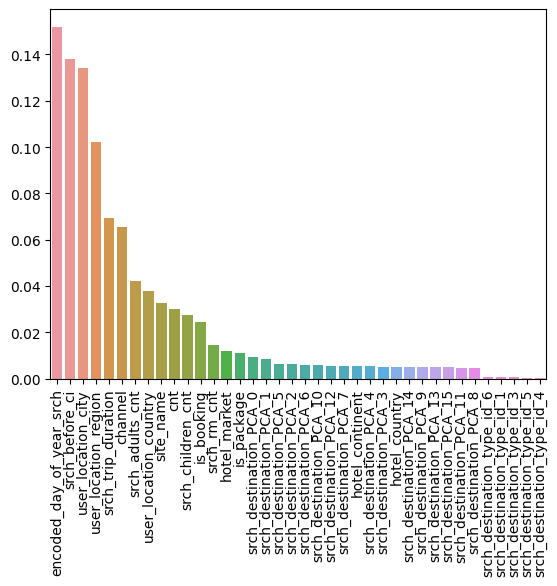

Text(0.5, 1.0, 'feature importance')

In [37]:
feat_imps = zip(x_labels, rfc_model.feature_importances_)
feats, imps = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps)), key = lambda x: x[1], reverse = True)))
ax = sns.barplot(list(feats), list(imps))
ax.tick_params(axis='x',rotation=90)
plt.show()
plt.title('feature importance')

# Tuning hyper parameter - random forest model

In [25]:
feat_number = [13,11,9,7,5]
min_imp_dec = [1e-8,1e-7,1e-6,1e-5,1e-4]

scores = []
fn = []
im = []

for i in range(5):
    for j in range(5):
        clf = RandomForestClassifier(max_features = feat_number[i], n_estimators=20, max_depth = 10, min_impurity_decrease = min_imp_dec[j], n_jobs=10)
        clf.fit(x_train,y_train)
        score = clf.score(x_val,y_val)
        scores.append(score)
        fn.append(feat_number[i])
        im.append(min_imp_dec[j])
        print(i,j,score)

0 0 0.1456583599747756
0 1 0.14604007249400502
0 2 0.14500265107188012
0 3 0.14415347144006016
0 4 0.1270496132154103
1 0 0.14379999518937647
1 1 0.14579535816660863
1 2 0.14558515483410148
1 3 0.1426423081790012
1 4 0.12564721187763866
2 0 0.1439369933812095
2 1 0.14302611227367845
2 2 0.1451427866268849
2 3 0.14454459604880482
2 4 0.12437239664218477
3 0 0.1434601141791037
3 1 0.14152122373896303
3 2 0.14405516739401203
3 3 0.1407138756160997
3 4 0.12260396960104245
4 0 0.14350299147578427
4 1 0.14034471254955727
4 2 0.14031333891783979
4 3 0.13731506551337197
4 4 0.11923967049320394


In [21]:
rfc_hyper_model = RandomForestClassifier(n_estimators=20, max_features = 13, max_depth = 35, min_impurity_decrease = 1e-7, n_jobs=10).fit(x_train,y_train)

In [23]:
# train score
#print('score on training set: ', rfc_model.score(x_train,y_train))
#val score
print('score on validation set: ', rfc_hyper_model.score(x_val,y_val))
#test score
print('score on testing set: ', rfc_hyper_model.score(x_test,y_test))


score on validation set:  0.21840230826266424
score on testing set:  0.24278363884310658


In [24]:
# predict 5 hotel clusters 
def predict_test(model, x, y):
    book_prob = pd.DataFrame(model.predict_proba(x), index=x.index)
    display(book_prob)
    
    top_5 = book_prob.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=5)
    
    total_num = len(top_5)
    
    pred_true = pd.DataFrame(np.tile(y.to_numpy(), (5,1)).T, index=x.index) == top_5
    correct_num = pred_true.sum().sum()
    
    accuracy = correct_num/total_num
    print('accuracy in testing set: ', accuracy)
    display(top_5)
    
    map_5 = 0
    for i in range(5):
        map_5 += (pred_true.sum()/len(y))[i]*(1/(i+1))
    print('map@5: ', map_5)

In [26]:
predict_test(rfc_hyper_model, x_test, y_test)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,0.0,0.000000,0.004340,0.000000,0.000000,0.000000,0.061458,0.001042,0.000000,...,0.000521,0.065278,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.0,0.000000,0.001007,0.000000,0.000671,0.000000,0.104027,0.000000,0.000000,...,0.000000,0.000000,0.0,0.001007,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.019416,0.009416,0.000000,0.000000,...,0.000000,0.004545,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.0,0.000000,0.000000,0.105870,0.001683,0.000424,0.000000,0.000000,0.058212,...,0.000000,0.007490,0.0,0.000000,0.000648,0.0,0.026226,0.000000,0.000000,0.000000
4,0.146280,0.0,0.000000,0.000000,0.000000,0.008102,0.000000,0.000000,0.000000,0.000000,...,0.000926,0.000000,0.0,0.000000,0.000000,0.0,0.052941,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597630,0.000000,0.0,0.223351,0.000000,0.001703,0.000464,0.308434,0.000000,0.000000,0.057170,...,0.000000,0.056171,0.0,0.000000,0.005155,0.0,0.000000,0.001515,0.000000,0.000000
597631,0.000000,0.0,0.182369,0.002632,0.000000,0.069219,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.002703,0.0,0.000000,0.000000,0.0,0.000000,0.001351,0.000000,0.000000
597632,0.000797,0.0,0.000000,0.000000,0.000000,0.154582,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000199,0.000000,0.0,0.009761,0.000000,0.000000,0.000000
597633,0.000000,0.0,0.000000,0.000000,0.000000,0.000893,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.122321,0.000000,0.000000


accuracy in testing set:  0.566740569076443


,0,1,2,3,4
0,15,16,48,91,7
1,40,85,7,58,30
2,43,75,15,23,30
3,50,33,4,16,42
4,26,34,0,68,96
...,...,...,...,...,...
597630,6,2,18,9,15
597631,11,2,58,16,59
597632,11,63,5,17,89
597633,59,18,97,33,21


map@5:  0.35835476503216845


In [27]:
x_labels = x_test.columns[0:27].to_list()
for i in range(16):
    x_labels.extend(['srch_destination_PCA_'+str(i)])
x_labels

['site_name',
 'user_location_country',
 'user_location_region',
 'user_location_city',
 'is_package',
 'channel',
 'srch_adults_cnt',
 'srch_children_cnt',
 'srch_rm_cnt',
 'is_booking',
 'cnt',
 'hotel_continent',
 'hotel_country',
 'hotel_market',
 'srch_before_ci',
 'srch_trip_duration',
 'encoded_day_of_year_srch',
 'srch_destination_type_id_0',
 'srch_destination_type_id_1',
 'srch_destination_type_id_2',
 'srch_destination_type_id_3',
 'srch_destination_type_id_4',
 'srch_destination_type_id_5',
 'srch_destination_type_id_6',
 'srch_destination_type_id_7',
 'srch_destination_type_id_8',
 'srch_destination_type_id_9',
 'srch_destination_PCA_0',
 'srch_destination_PCA_1',
 'srch_destination_PCA_2',
 'srch_destination_PCA_3',
 'srch_destination_PCA_4',
 'srch_destination_PCA_5',
 'srch_destination_PCA_6',
 'srch_destination_PCA_7',
 'srch_destination_PCA_8',
 'srch_destination_PCA_9',
 'srch_destination_PCA_10',
 'srch_destination_PCA_11',
 'srch_destination_PCA_12',
 'srch_destina

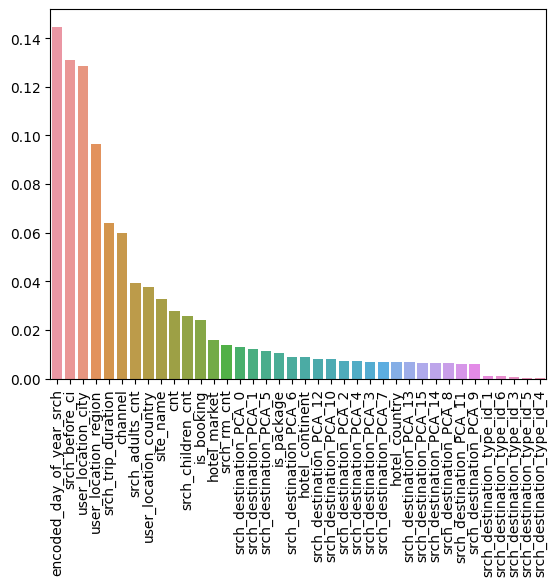

Text(0.5, 1.0, 'feature importance')

In [29]:
feat_imps = zip(x_labels, rfc_hyper_model.feature_importances_)
feats, imps = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps)), key = lambda x: x[1], reverse = True)))
ax = sns.barplot(list(feats), list(imps))
ax.tick_params(axis='x',rotation=90)
plt.show()
plt.title('feature importance')